# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report
import pickle

import os
os.makedirs('saved_models', exist_ok=True)

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight
transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Models

In [2]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [3]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy


nr_features = 768
batch_size = 32
learning_rate = 0.0001
epochs = 10
patience = 2
class_weight_beta = 0.9999

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [5]:

def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset):
    user_act_types_list = []
    seen_slots_embeddings = []
    to_be_retrieved_list = []
    
    nr = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        acts_seen_in_dialogue = []
        to_be_retrieved_seen_in_dialogue = []
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            # if speaker == 0:
            #     # if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
            #         # skip_bot = True
            #         # continue
                
            #     if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     skip_bot = False
            # else:
            #     if skip_bot:
            #         continue
            if speaker == 0:
                skip_bot = False
                if not any(da.startswith("Hotel") or da.startswith("Restaurant") or da.startswith("Booking") for da in act_types):
                    skip_bot = True
                    continue
            elif skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                elif domain in ['hotel', 'restaurant', 'booking', 'general']: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and 'choice' not in slot_name and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name for slot_name, _ in act_type_relevant_slots]))
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                
                acts_seen_in_dialogue.append(slots_per_act_type)
                input_text = utterance + ' | SLOTS' + ', '.join(slots_per_act_type)

                print("INPUT:", input_text)
                tokenized_seen_slots = transformer_tokenizer(input_text)
                with torch.no_grad():
                    embedding = embedding_matrix[tokenized_seen_slots.input_ids].detach().numpy()
                seen_slots_embeddings.append(embedding)
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                to_be_retrieved_list.append(list(to_be_retrieved))
                to_be_retrieved_seen_in_dialogue.append(list(to_be_retrieved))
                print("OUTPUT:", list(to_be_retrieved))
                
            
            
    return user_act_types_list, seen_slots_embeddings, to_be_retrieved_list

In [6]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_user_act_types_list, train_seen_slots_embeddings, train_to_be_retrieved_list = extract_to_be_retrieved_info(train)
    test_user_act_types_list, test_seen_slots_embeddings, test_to_be_retrieved_list = extract_to_be_retrieved_info(test)
    val_user_act_types_list, val_seen_slots_embeddings, val_to_be_retrieved_list = extract_to_be_retrieved_info(val)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

  1%|          | 66/6321 [00:00<00:09, 651.55it/s]

INPUT: i need a place to dine in the center thats expensive | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-food']
INPUT: Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation? | SLOTSrestaurant-request-food:?
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel? | SLOTShotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:?
OUTPUT: ['hotel-name', 'hotel-area', 'restaurant-name', 'restaurant-phone']
INPUT: Yes. Can you book it for me? | SLOTS
OUTPUT: []
INPUT: i want to book it for 2 people and 2 nights starting from saturday. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2
OUTPUT: ['hotel-ref']
INPUT: Guten Tag, I am staying overnight in Cambridge and need a place to sleep. I need free parki

  3%|▎         | 204/6321 [00:00<00:09, 617.51it/s]

INPUT: Okay. I'd like a hotel that includes free parking then. | SLOTShotel-inform-parking:yes, hotel-inform-type:hotel
OUTPUT: ['hotel-name']
INPUT: Please book it for 7 people for 5 nights starting Thursday. | SLOTShotel-inform-bookday:thursday, hotel-inform-bookpeople:7, hotel-inform-bookstay:5
OUTPUT: ['hotel-ref']
INPUT: I am looking for an expensive gastropub restaurant in Cambridge | SLOTSrestaurant-inform-food:gastropub, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-area']
INPUT: Yes. We need a table for 2 at 14:45 on Saturday. | SLOTSrestaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:14:45
OUTPUT: []
INPUT: How about at 13:45? | SLOTSrestaurant-inform-booktime:13:45
OUTPUT: ['restaurant-ref']
INPUT: Thank you so much. Can you help me find a place to stay? I would like a 3 star place that's in the expensive price range. | SLOTShotel-inform-pricerange:expensive, hotel-inform-stars:3
OUTPUT: ['hotel-name', 'hotel-area']
IN

  5%|▌         | 333/6321 [00:00<00:10, 596.50it/s]

I don't care | SLOTSrestaurant-inform-food:dontcare
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: is there another one as well? | SLOTSrestaurant-request-name:?
OUTPUT: ['restaurant-name', 'restaurant-food']
INPUT: Yes could you give me the phone number for The Nirala? | SLOTSrestaurant-inform-name:nirala, restaurant-request-phone:?
OUTPUT: ['restaurant-phone']
INPUT: Which part of town it is in ? | SLOTSrestaurant-inform-area:north
OUTPUT: ['restaurant-area']
INPUT: I am looking for an upscale Chinese food restaurant in Cambridge; can you make a recommendation? | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-pricerange']
INPUT: I need something in the Center of town. | SLOTSrestaurant-inform-area:centre
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: That sounds fine. Can you give me the address and phone number? | SLOTSrestaurant-reque

  7%|▋         | 469/6321 [00:00<00:09, 638.08it/s]

[]
INPUT: Would it be possible to book this for one night? | SLOTShotel-inform-bookstay:1
OUTPUT: ['hotel-ref', 'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople']
INPUT: I'm looking for a 3-star lodging with free wifi. | SLOTShotel-inform-internet:yes, hotel-inform-stars:3
OUTPUT: ['hotel-internet', 'hotel-stars']
INPUT: I would like it to be in the west | SLOTShotel-inform-area:west
OUTPUT: ['hotel-name']
INPUT: That sounds like it will work. Can I book that for 3 nights starting Wednesday? | SLOTShotel-inform-bookday:wednesday, hotel-inform-bookstay:3, hotel-inform-stars:3
OUTPUT: ['hotel-ref', 'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople']
INPUT: I also am looking for somewhere to get afternoon tea. | SLOTSrestaurant-inform-food:afternoon tea
OUTPUT: ['restaurant-food']
INPUT: Let's try a Chinese restaurant instead. | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-food']
INPUT: No I'm not too picky. You can just select one for me and then please book a table fo

  9%|▉         | 598/6321 [00:00<00:09, 621.57it/s]

OUTPUT: ['hotel-postcode', 'hotel-address']
INPUT: Yes, please. I'm looking for an Italian restaurant in the east. Price range doesn't matter. | SLOTSrestaurant-inform-area:east, restaurant-inform-food:italian, restaurant-inform-pricerange:dontcare
OUTPUT: []
INPUT: I want to eat in the East. | SLOTSrestaurant-inform-area:east
OUTPUT: ['restaurant-name']
INPUT: Not at this time but can I please get their postcode? | SLOTSrestaurant-request-postcode:?
OUTPUT: ['restaurant-postcode']
INPUT: Just 1 ticket please, and I am also looking for a cheap restaurant located in the west, can you help me find one? | SLOTSrestaurant-inform-area:west, restaurant-inform-pricerange:cheap, train-inform-bookpeople:1
OUTPUT: []
INPUT: No, I need a cheap restaurant located in the west that serves Vietnamese food. | SLOTSrestaurant-inform-area:west, restaurant-inform-food:vietnamese, restaurant-inform-pricerange:cheap
OUTPUT: ['restaurant-area', 'restaurant-food', 'restaurant-name', 'restaurant-pricerange']


 11%|█▏        | 723/6321 [00:01<00:09, 611.26it/s]

INPUT: Hello, I'm looking for a hotel to stay in during my visit to Cambridge. Can you please help me find something in the moderate price range? No specific amenities needed. | SLOTShotel-inform-pricerange:moderate, hotel-inform-type:hotel
OUTPUT: []
INPUT: In the west. And 3 stars, please. | SLOTShotel-inform-area:west, hotel-inform-stars:3
OUTPUT: []
INPUT: If that is the case, can you look for a hotel that has free wifi? Thanks | SLOTShotel-inform-internet:yes
OUTPUT: []
INPUT: Could you try looking for something for Wednesday? | SLOTShotel-inform-bookday:wednesday
OUTPUT: []
INPUT: Are there any 3 star hotels in the West? | SLOTShotel-inform-area:west, hotel-inform-stars:3
OUTPUT: ['hotel-pricerange']
INPUT: Yes, please try to find something else. | SLOTShotel-inform-area:dontcare
OUTPUT: ['hotel-pricerange', 'hotel-type', 'hotel-stars']
INPUT: That would be fine,can you book it for me? | SLOTShotel-inform-pricerange:moderate
OUTPUT: ['hotel-area', 'hotel-pricerange', 'hotel-type'

 13%|█▎        | 852/6321 [00:01<00:08, 611.91it/s]

INPUT: Yes, Tuesday, the same day as the restaurant booking, can I please get a departure time as well? | SLOTSrestaurant-inform-bookday:tuesday, train-request-leaveat:?
OUTPUT: []
INPUT: I'd like a jamaican restaurant please. | SLOTSrestaurant-inform-food:jamaican
OUTPUT: ['restaurant-food']
INPUT: alright then. how about portuguese? | SLOTSrestaurant-inform-food:portuguese
OUTPUT: ['restaurant-area', 'restaurant-name']
INPUT: May I have the phone number and address for the south location? | SLOTSrestaurant-inform-area:south, restaurant-request-address:?, restaurant-request-phone:?
OUTPUT: ['restaurant-address', 'restaurant-phone']
INPUT: Hi, I'm looking for a European restaurant. | SLOTSrestaurant-inform-food:european
OUTPUT: ['restaurant-pricerange', 'restaurant-name', 'restaurant-address', 'restaurant-food']
INPUT: Is this actually located in the centre area? I just want to make sure. | SLOTSrestaurant-inform-area:centre
OUTPUT: ['restaurant-area']
INPUT: Yes. Please reserve it for

 16%|█▌        | 983/6321 [00:01<00:08, 624.07it/s]

OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-internet', 'hotel-area']
INPUT: Yes, please. 7 people, Monday, for 3 nights. | SLOTShotel-inform-bookday:monday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3
OUTPUT: []
INPUT: Yes, please book rooms for 7 people for 3 nights starting on Monday. | SLOTShotel-inform-bookstay:3
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-internet', 'hotel-area', 'hotel-ref']
INPUT: Can you help me find a hotel today? | SLOTShotel-inform-type:hotel
OUTPUT: []
INPUT: I was hoping for a hotel in the east that is cheap. | SLOTShotel-inform-area:east, hotel-inform-pricerange:cheap
OUTPUT: []
INPUT: A 4 star hotel with wifi and free parking ? | SLOTShotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-stars:4
OUTPUT: ['hotel-pricerange', 'hotel-name', 'hotel-postcode', 'hotel-address']
INPUT: That is all I need for the hotel. But I am looking for a place to dine. | SLOTS
OUTPUT: []
INPUT: I'm actually interest

 18%|█▊        | 1114/6321 [00:01<00:08, 639.64it/s]

I would like a guesthouse. The star rating doesn't matter, but the hotel should include free wifi. | SLOTShotel-inform-internet:yes, hotel-inform-stars:dontcare, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-type', 'hotel-stars']
INPUT: Can you book Acorn Guest House for 4 people for 2 nights starting friday? | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2, hotel-inform-name:acorn guest house
OUTPUT: ['hotel-name', 'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople', 'hotel-ref']
INPUT: I would like a moderately priced restaurant in the east part of town | SLOTSrestaurant-inform-area:east, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: No, the west part of town | SLOTSrestaurant-inform-area:west
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: What is the address? | SLOTSrestaurant-request-address:?
OUTPUT: ['restau

 20%|█▉        | 1248/6321 [00:01<00:07, 646.17it/s]

OUTPUT: ['hotel-name', 'hotel-area', 'hotel-pricerange', 'hotel-type']
INPUT: Yes, please. I'd like to book for 4 people for 2 nights staring on Saturday. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2
OUTPUT: ['hotel-ref']
INPUT: I'm looking for a place to stay. I'd prefer a guesthouse with four stars. | SLOTShotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: ['hotel-type', 'hotel-stars']
INPUT: I'd like a moderately priced place please. | SLOTShotel-inform-pricerange:moderate
OUTPUT: ['hotel-pricerange', 'hotel-stars']
INPUT: If you could recommend any one of them that would be great. I need the postcode, phone number and the area the hotel is in please. | SLOTShotel-request-area:?, hotel-request-phone:?, hotel-request-postcode:?
OUTPUT: []
INPUT: Area of town doesn't matter. | SLOTShotel-request-area:?
OUTPUT: []
INPUT: I'm looking for a particular restaurant. Its name is called the hotpot. | SLOTSrestaurant-inform-name:the hotpot
OU

 22%|██▏       | 1387/6321 [00:02<00:07, 661.42it/s]

OUTPUT: ['restaurant-name']
INPUT: book a table for 8 people at 19:00 on wednesday. | SLOTSrestaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:19:00
OUTPUT: ['restaurant-ref']
INPUT: I am looking for a cuban restaurant in the north part of town. | SLOTSrestaurant-inform-area:north, restaurant-inform-food:cuban
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: I still want the north part of town, but look for Asian Oriental food instead please. | SLOTSrestaurant-inform-area:north, restaurant-inform-food:asian oriental
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Yes, I would like their address and phone number, please. | SLOTSrestaurant-request-address:?, restaurant-request-phone:?
OUTPUT: ['restaurant-name', 'restaurant-address', 'restaurant-phone']
INPUT: I am trying to find a restaurant in the south of the city that serves modern American food. | SLOTSrestaurant-inform-area:south, restaurant-inform-food:moder

 23%|██▎       | 1454/6321 [00:02<00:07, 629.29it/s]

INPUT: Yes, tell me about those. | SLOTS
OUTPUT: ['hotel-internet', 'hotel-name', 'hotel-stars', 'hotel-parking']
INPUT: What about the other hotel? | SLOTS
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-address', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: Could you book me a room at one of those? I need it for 6 people and 2 nights starting from saturday. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:6, hotel-inform-bookstay:2
OUTPUT: ['hotel-ref', 'hotel-name']
INPUT: I would like a restaurant that serves portuguese food | SLOTSrestaurant-inform-food:portuguese
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: what is their address | SLOTSrestaurant-request-address:?
OUTPUT: ['restaurant-address']
INPUT: I'd like to find a moderately priced Italian restaurant. | SLOTSrestaurant-inform-food:italian, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-food']
INPUT: I would like more va

 25%|██▌       | 1582/6321 [00:02<00:07, 618.12it/s]

OUTPUT: ['restaurant-food']
INPUT: I am interested in Chinese food. | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Yes, please! Can I have a table for 1 at Charlie Chan on Sunday at 14:15? | SLOTSrestaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:14:15, restaurant-inform-name:charlie chan
OUTPUT: ['restaurant-ref']
INPUT: I am looking for a place to stay that is a guesthouse located in the center of town. | SLOTShotel-inform-area:centre, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-area', 'hotel-type', 'hotel-stars']
INPUT: The hotel should have a star of 0 and should include free parking. | SLOTShotel-inform-parking:yes, hotel-inform-stars:0, hotel-inform-type:hotel
OUTPUT: ['hotel-name', 'hotel-type', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: Yes, four people for four nights, starting Sunday, please. | SLOTShotel-inform-bookday:sunday, hotel-inform-boo

 27%|██▋       | 1710/6321 [00:02<00:07, 614.56it/s]

OUTPUT: []
INPUT: I am interested in cheap restaurants. | SLOTSrestaurant-inform-pricerange:cheap
OUTPUT: ['restaurant-name', 'restaurant-address']
INPUT: Yes please, just me on Tuesday, at 15:30. | SLOTSrestaurant-inform-bookday:tuesday, restaurant-inform-booktime:15:30
OUTPUT: ['booking-ref']
INPUT: Yes, I'm also looking for a place to stay for the night, and I can't break the bank on it either. | SLOTS
OUTPUT: ['hotel-pricerange', 'hotel-type']
INPUT: Any area is fine as long as it is 4 star and a guesthouse. | SLOTShotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-stars', 'hotel-area']
INPUT: That sounds great! Can you book a room there for 3 nights? Just me, and I'll be arriving on Tuesday. | SLOTShotel-inform-bookday:tuesday, hotel-inform-bookstay:3
OUTPUT: ['booking-ref']
INPUT: I need a taxi to take me from the hotel to the restaurant. I need to make sure I get there by 15:30. | SLOTSrestaurant-inform-booktime:15:

 29%|██▉       | 1834/6321 [00:02<00:07, 610.24it/s]

OUTPUT: []
INPUT: Thank you very much. Could you help me get a guesthouse as well? | SLOTShotel-inform-type:guesthouse
OUTPUT: []
INPUT: I would like something in the moderate price range. | SLOTShotel-inform-pricerange:moderate, train-request-price:?
OUTPUT: []
INPUT: I do not need it to be booked. Can I just get the postcode and whether it has internet? | SLOTShotel-request-internet:?, hotel-request-postcode:?
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-internet', 'hotel-area']
INPUT: Yes, does the guesthouse have a star rating of 3? | SLOTShotel-inform-stars:3
OUTPUT: ['hotel-name', 'hotel-address', 'hotel-stars', 'hotel-phone']
INPUT: I am looking for a moderate priced restaurant in the south part of town. Could you recommend me three restaurants? | SLOTSrestaurant-inform-area:south, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Is there a third restaurant? | SLOTS
OUTPUT: 

 31%|███       | 1964/6321 [00:03<00:06, 626.93it/s]

['restaurant-ref', 'restaurant-name']
INPUT: Yes, I'll also need a taxi to commute between the two locations. I'll need to arrive at the restaurant by the dining time. | SLOTS
OUTPUT: []
INPUT: I'm looking for a hotel to stay in. It should have free internet and parking. | SLOTShotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-type:hotel
OUTPUT: []
INPUT: I'd like a place that is cheap but still has free wifi and free parking. Do you have a place like that? | SLOTShotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:cheap
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: No, thanks. I would like the postcode to that hotel, please. | SLOTShotel-request-postcode:?
OUTPUT: ['hotel-postcode', 'hotel-type']
INPUT: I'd like a restaurant with Korean food please. | SLOTSrestaurant-inform-food:korean
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
IN

 33%|███▎      | 2089/6321 [00:03<00:07, 598.98it/s]

INPUT: Did you check the east area? | SLOTSrestaurant-inform-area:east
OUTPUT: ['restaurant-area']
INPUT: How about expensive indian food in the east area? | SLOTSrestaurant-inform-food:indian
OUTPUT: ['restaurant-name']
INPUT: Can you give me the postal code and phone number for Pipasha restaurant? | SLOTSrestaurant-inform-name:pipasha restaurant, restaurant-request-phone:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode', 'restaurant-phone']
INPUT: Can you tell me more about the peking restaurant? Thank you. | SLOTSrestaurant-inform-name:peking restaurant
OUTPUT: ['restaurant-area', 'restaurant-address', 'restaurant-food']
INPUT: Great! Can you book a table for 3 there? We'd like something at 11:15 on Wednesday, please. | SLOTSrestaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:11:15
OUTPUT: ['restaurant-ref']
INPUT: What have you got on the west side, in the way of places to stay offering free wifi? | SLOTShotel-inform-area:we

 35%|███▍      | 2210/6321 [00:03<00:07, 580.75it/s]

OUTPUT: ['hotel-area', 'hotel-type']
INPUT: No thank you but I do need the address please? | SLOTShotel-request-address:?
OUTPUT: ['hotel-postcode', 'hotel-address']
INPUT: Can you find a moderately priced restaurant in the east side? | SLOTSrestaurant-inform-area:east, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: I would like the one with the italian food. Can you see if I can book a table for 7 people at 14:30 on tuesday there please? | SLOTSrestaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:14:30
OUTPUT: []
INPUT: How about either of the Indian restaurants in the same area and price range? | SLOTSrestaurant-inform-food:indian
OUTPUT: ['restaurant-address']
INPUT: I would like to try the restaurant at 451 Newmarket Road Fen Ditton since it's close by. Can you try a booking, please? | SLOTS
OUTPUT: ['restaurant-ref']
INPUT: Yes I'm looking for a place to stay in the south

 37%|███▋      | 2326/6321 [00:03<00:07, 549.71it/s]

I also need the postcode and address please. | SLOTSrestaurant-request-address:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode', 'restaurant-address']
INPUT: I am looking for a moderately price British restaurant. | SLOTSrestaurant-inform-food:british, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: The restaurant should be in the centre. | SLOTSrestaurant-inform-area:centre
OUTPUT: ['restaurant-name', 'restaurant-address']
INPUT: Sounds good. Can you book it for 4 people at 14:30 on saturday? I'll need the reference number. | SLOTSrestaurant-inform-bookday:saturday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:14:30
OUTPUT: ['booking-ref']
INPUT: Can you hold the reservation for 30 minutes instead? | SLOTSrestaurant-inform-booktime:30 minutes
OUTPUT: []
INPUT: No that's okay but I am looking for a hotel in the same area as the restaurant can you please help? | SLOTShotel-inform-area:centr

 39%|███▊      | 2449/6321 [00:04<00:06, 578.48it/s]

OUTPUT: ['restaurant-food']
INPUT: How about mediterranean food? | SLOTSrestaurant-inform-food:mediterranean
OUTPUT: ['restaurant-name', 'restaurant-food']
INPUT: Can I have the postcode, address, and phone number, please? | SLOTSrestaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode', 'restaurant-address', 'restaurant-phone']
INPUT: I also need the name and number for an expensive restaurant in the city center. | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: Yes expensive Korean food. | SLOTSrestaurant-inform-food:korean
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Yes, please book a table. | SLOTS
OUTPUT: []
INPUT: for 2 peopl at 18:15 on sunday | SLOTSrestaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:15
OUTPUT: ['restaurant-ref']
INPUT: Thanks. I'm also looking for an expensive

 41%|████      | 2579/6321 [00:04<00:06, 613.45it/s]

I would like the phone number of a cheap restaurant in the centre of town. | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:cheap, restaurant-request-phone:?
OUTPUT: ['restaurant-food']
INPUT: Please recommend a restaurant. I really do not care about the food type. Thank you. | SLOTSrestaurant-inform-food:dontcare, restaurant-request-food:?
OUTPUT: []
INPUT: I would need the phone number and food type. | SLOTSrestaurant-request-food:?, restaurant-request-phone:?
OUTPUT: ['restaurant-phone', 'restaurant-name', 'restaurant-food']
INPUT: I am also looking for a restaurant that serves german food at the moderate price range. | SLOTSrestaurant-inform-food:german, restaurant-inform-pricerange:moderate, train-request-price:?
OUTPUT: []
INPUT: Can you recommend a Chinese restaurant since German is not available? | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-name']
INPUT: Ok, I need a table for 2 at 18:45 on the same day please. | SLOTSrestaurant-inform-bookday:fr

 43%|████▎     | 2711/6321 [00:04<00:05, 636.67it/s]


OUTPUT: []
INPUT: That's okay. How about Italian food? | SLOTSrestaurant-inform-food:italian
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-pricerange']
INPUT: Yes, for Friday at 19:00 for 6 people. | SLOTSrestaurant-inform-bookday:friday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:19:00
OUTPUT: ['booking-ref']
INPUT: Hi, I am planning a trip. Have you heard of a particular hotel? I think it is called the Carolina Bed and Breakfast. | SLOTShotel-inform-name:carolina bed and breakfast
OUTPUT: ['hotel-type', 'hotel-address', 'hotel-stars']
INPUT: Great! I need reservations for 3 people, for 3 nights, beginning on Thursday. | SLOTShotel-inform-bookday:thursday, hotel-inform-bookpeople:3, hotel-inform-bookstay:3
OUTPUT: ['hotel-ref']
INPUT: Hello, I'd like some information on a restaurant in the centre. | SLOTSrestaurant-inform-area:centre
OUTPUT: ['restaurant-area']
INPUT: I would like african food. | SLOTSrestaurant-inform-food:african
OUTPUT: ['restaurant-na

 44%|████▍     | 2775/6321 [00:04<00:05, 617.42it/s]

OUTPUT: ['restaurant-address', 'restaurant-phone']
INPUT: I want an expensive restaurant in the South. | SLOTSrestaurant-inform-area:south, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-food']
INPUT: Mexican will would great. I need a reservation for 2 at 19:30 on Monday. | SLOTSrestaurant-inform-bookday:monday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:19:30, restaurant-inform-food:mexican
OUTPUT: ['restaurant-booktime', 'restaurant-name', 'restaurant-bookday', 'restaurant-ref', 'restaurant-address']
INPUT: Yes can you book me a taxi to take me to the restaurant from the museum? | SLOTS
OUTPUT: []
INPUT: I'm looking for an expensive restaurant in the west part of town. | SLOTSrestaurant-inform-area:west, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: The restaurant should serve british food. | SLOTSrestaurant-inform-food:british
OUTPUT: ['restaurant-name']
INPUT: Yes please and I will need their phone number for reference please. | SLOTSrestaur

 46%|████▌     | 2904/6321 [00:04<00:05, 600.36it/s]

OUTPUT: []
INPUT: No, but I would prefer a guest house. | SLOTShotel-inform-area:dontcare
OUTPUT: ['hotel-area']
INPUT: Just any moderate guest house with 4 stars that you recommend. I need it for 3 nights for my group. For the same day we are traveling. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:3, hotel-inform-stars:4
OUTPUT: ['hotel-ref', 'hotel-name', 'hotel-bookday', 'hotel-bookstay']
INPUT: Are there any restaurants in town that serve modern american food? | SLOTSrestaurant-inform-food:modern american
OUTPUT: []
INPUT: What about any expensive restaurants with traditional American food in the centre of town? | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:traditional american, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-area', 'restaurant-pricerange']
INPUT: Sure how about Italian? | SLOTSrestaurant-inform-food:italian
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: The restaurant so

 48%|████▊     | 3030/6321 [00:04<00:05, 612.01it/s]

OUTPUT: ['restaurant-pricerange', 'restaurant-name', 'restaurant-address', 'restaurant-food']
INPUT: That sounds great. Can I get a postcode? Thanks! | SLOTSrestaurant-request-postcode:?
OUTPUT: ['hotel-postcode']
INPUT: Great. I also need a moderate hotel in the south. | SLOTShotel-inform-area:south, hotel-inform-pricerange:moderate, hotel-inform-type:hotel
OUTPUT: []
INPUT: Can you suggest something with free wifi and a 3 star rating? I'm open to less expensive price ranges. | SLOTShotel-inform-internet:yes, hotel-inform-pricerange:cheap, hotel-inform-stars:3, train-request-price:?
OUTPUT: ['hotel-name', 'hotel-pricerange']
INPUT: I would like something in the moderate price range. | SLOTShotel-inform-pricerange:moderate, train-request-price:?
OUTPUT: ['hotel-pricerange', 'hotel-type', 'hotel-stars', 'hotel-internet', 'hotel-area']
INPUT: I think I'd prefer a hotel. I need it for 3 people, 2 nights starting Friday. I need a reference number please. | SLOTShotel-inform-bookday:friday,

 50%|████▉     | 3159/6321 [00:05<00:05, 603.20it/s]

OUTPUT: ['restaurant-pricerange', 'restaurant-food']
INPUT: What about a cheap korean restaurant in the north? | SLOTSrestaurant-inform-area:north, restaurant-inform-pricerange:cheap
OUTPUT: []
INPUT: What about Italian food? | SLOTSrestaurant-inform-food:italian
OUTPUT: []
INPUT: Yes it does have to be. | SLOTSrestaurant-inform-pricerange:cheap
OUTPUT: ['restaurant-name']
INPUT: Sure. I'd like a reservation for Tuesday. | SLOTSrestaurant-inform-bookday:tuesday
OUTPUT: []
INPUT: 18:00. Also I need the address, postcode and phone number, please. | SLOTSrestaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode', 'restaurant-address', 'restaurant-phone']
INPUT: Yes, I am also looking for a cheap hotel in the same area as the restaurant. | SLOTShotel-inform-area:north, hotel-inform-pricerange:cheap, restaurant-inform-pricerange:cheap
OUTPUT: ['hotel-name']
INPUT: Yes please book it for four people in the three nights starting on S

 52%|█████▏    | 3294/6321 [00:05<00:04, 639.37it/s]

OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-address']
INPUT: Hi, you can help me by getting me some options about where to stay on the North end. Preferably a 4 star hotel | SLOTShotel-inform-area:north, hotel-inform-stars:4, hotel-inform-type:hotel
OUTPUT: ['hotel-name']
INPUT: Are there any hotels available, instead of a guesthouse? | SLOTShotel-inform-type:guesthouse
OUTPUT: ['hotel-area', 'hotel-type', 'hotel-stars']
INPUT: Ok, let's go with guesthouse. A moderately priced one, 4 stars. | SLOTShotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-postcode', 'hotel-address']
INPUT: Do they have free parking? | SLOTShotel-request-parking:?
OUTPUT: ['hotel-parking']
INPUT: I don't need a room right now, but I would like to know if there is a Persian restaurant in the north. | SLOTSrestaurant-inform-area:north, restaurant-inform-food:persian
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: Are there any it

 54%|█████▍    | 3428/6321 [00:05<00:04, 635.09it/s]

OUTPUT: ['restaurant-area', 'restaurant-address', 'restaurant-phone']
INPUT: Can you please provide the full address? | SLOTSrestaurant-request-name:?
OUTPUT: ['restaurant-postcode', 'restaurant-address']
INPUT: I want to go all out this St Patricks day, can you find me an Irish restaurant? Lets go with an expensive one. | SLOTSrestaurant-inform-food:irish, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: How about an expensive Mexican restaurant then? | SLOTSrestaurant-inform-food:mexican, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-area', 'restaurant-name']
INPUT: Can I just get the phone number for now? | SLOTSrestaurant-request-phone:?
OUTPUT: ['restaurant-phone']
INPUT: I'm looking for a place to dine. The restaurant should serve japanese food and should be in the centre. | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:japanese
OUTPUT: ['restaurant-name']
INPUT: I'd like somewhere expensive, is it? | SLOTSrestaurant-inform-pricerange:expensive


 56%|█████▌    | 3554/6321 [00:05<00:04, 581.26it/s]

I'd like a zero star hotel that has wifi. | SLOTS
OUTPUT: ['hotel-type', 'hotel-stars']
INPUT: Sure, let's look for a 4 star hotel instead. | SLOTShotel-inform-stars:4
OUTPUT: []
INPUT: As long as it's 4 star that's all I just need one for 5 people for 4 nights starting monday. | SLOTShotel-inform-bookday:monday, hotel-inform-bookpeople:5, hotel-inform-bookstay:1, hotel-inform-stars:4
OUTPUT: ['hotel-name', 'hotel-pricerange']
INPUT: OK, lets give it a try. | SLOTShotel-inform-name:cambridge belfry, hotel-inform-stars:4
OUTPUT: []
INPUT: Yes, please book the hotel. | SLOTS
OUTPUT: []
INPUT: Yes how about 1 night | SLOTShotel-inform-bookstay:1
OUTPUT: ['hotel-ref', 'hotel-bookstay']
INPUT: Yes, where can I find a hotel for 4 nights and 5 people, Tuesday through Friday? | SLOTShotel-inform-bookday:tuesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4
OUTPUT: ['hotel-name', 'hotel-bookday', 'hotel-bookpeople']
INPUT: That's ok. I do need to find a moderately priced Austrian restaura

 58%|█████▊    | 3671/6321 [00:06<00:04, 567.60it/s]

OUTPUT: []
INPUT: I like nice places, so definitely something expensive. I do want it to have free wifi though. | SLOTShotel-inform-internet:yes, hotel-inform-pricerange:expensive
OUTPUT: ['hotel-area', 'hotel-pricerange', 'hotel-type']
INPUT: I know this sounds crazy, but I'm looking for an expensive hotel with a 0 star rating. The area doesn't matter so much. | SLOTShotel-inform-area:dontcare, hotel-inform-stars:0, hotel-inform-type:hotel
OUTPUT: []
INPUT: How about a 4 star rating. I need it booked for 5 people, 4 nights starting from Tuesday and I will need the reference number. | SLOTShotel-inform-bookday:tuesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:4, hotel-inform-stars:4
OUTPUT: ['hotel-area', 'booking-name', 'booking-ref']
INPUT: Thanks so much! Can you please book me a taxi between the two places, arriving at the restaurant by the time of the reservation? | SLOTS
OUTPUT: []
INPUT: I'm also looking for a place to stay in the north. I'd like it to have a rating of 4

 60%|██████    | 3805/6321 [00:06<00:04, 612.05it/s]

OUTPUT: ['restaurant-ref', 'restaurant-name']
INPUT: I'm looking for a british restaurant in the centre of town. | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:british
OUTPUT: ['restaurant-name', 'restaurant-pricerange']
INPUT: Yes, can you book me a table at the Copper Kettle on Tuesday at 19:15 for 2 people? | SLOTSrestaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:19:15, restaurant-inform-name:copper kettle
OUTPUT: ['restaurant-ref']
INPUT: I'm looking to stay in a guesthouse while I'm there. I'd like a place that has free parking. | SLOTShotel-inform-parking:yes, hotel-inform-type:guesthouse
OUTPUT: ['hotel-type']
INPUT: No. What is available? | SLOTShotel-inform-area:dontcare, hotel-inform-pricerange:dontcare
OUTPUT: []
INPUT: Not at the moment. Can you recommend any moderately priced guesthouses to accommodate 7 people? | SLOTShotel-inform-bookpeople:7, hotel-inform-pricerange:moderate
OUTPUT: []
INPUT: Not particularly. I 

 62%|██████▏   | 3930/6321 [00:06<00:03, 610.75it/s]

OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-internet', 'hotel-parking']
INPUT: Yes, please book the Ashley Hotel. I need a booking for 7 people for 4 nights, starting from Friday. | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:7, hotel-inform-bookstay:4, hotel-inform-name:ashley hotel, hotel-inform-type:hotel
OUTPUT: ['hotel-ref']
INPUT: i need a place to stay | SLOTS
OUTPUT: []
INPUT: No specific area but it needs to have 2 stars and area needs to be in the north. It also needs to include free wifi. | SLOTShotel-inform-area:north, hotel-inform-internet:yes, hotel-inform-stars:2
OUTPUT: ['hotel-name']
INPUT: book for me one of your choice for 7 people and 2 nights starting on wednesday. | SLOTShotel-inform-bookday:wednesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2, hotel-inform-stars:2
OUTPUT: ['hotel-ref', 'hotel-name']
INPUT: Yes, I am also looking for a restaurant in the same area as the Ballare. | SLOTSrestaurant-inform-area:centre
OUTPUT

 64%|██████▍   | 4053/6321 [00:06<00:03, 600.86it/s]

['hotel-type', 'hotel-stars', 'hotel-area']
INPUT: I would like to make a reservation at the 4 star one please. | SLOTShotel-inform-stars:4
OUTPUT: ['hotel-name']
INPUT: Yes. Please book it for 5 people, starting Sunday, for 3 nights. | SLOTShotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5
OUTPUT: []
INPUT: Are you sure? Can you try again? If that doesn't work, is there another 4 star guesthouse in the centre that you can try? | SLOTShotel-inform-stars:4
OUTPUT: ['hotel-ref']
INPUT: Can you find a moderate price restaurant in the centre? | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:moderate
OUTPUT: []
INPUT: I would like to eat Chinese food, please. | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: Yes, please. Just go ahead and make a booking with your recommendation. I'll need a table on Sunday at 11:45. It will be 8 people. | SLOTSrestaurant-inform-bookday:sunday, 

 65%|██████▌   | 4114/6321 [00:06<00:03, 593.98it/s]


INPUT: I need to book it to 2 people for 4 nights starting from wednesday. | SLOTShotel-inform-bookday:wednesday, hotel-inform-bookpeople:2, hotel-inform-bookstay:4
OUTPUT: ['hotel-ref']
INPUT: Can you find me a Greek restaurant in the centre of Cambridge? | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:greek
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: Ok my second choice was british food can you find a british restaurant? | SLOTSrestaurant-inform-food:british
OUTPUT: ['restaurant-name', 'restaurant-address']
INPUT: Yes, please. It'll be for 2 people on Saturday at 12:00. | SLOTSrestaurant-inform-bookday:saturday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:12:00
OUTPUT: ['restaurant-ref']
INPUT: I want a restaurant in the centre of town. | SLOTSrestaurant-inform-area:centre
OUTPUT: []
INPUT: Yes, French food. | SLOTSrestaurant-inform-food:french
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Yes! I need at table for 6 at

 67%|██████▋   | 4232/6321 [00:06<00:03, 569.09it/s]

Okay. Can you try booking the El Shaddai for me fo Saturday for 2 people for 3 nights. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3, hotel-inform-name:el shaddai
OUTPUT: ['hotel-ref']
INPUT: I would like a moderately priced restaurant in the north part of town | SLOTSrestaurant-inform-area:north, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-area', 'restaurant-food', 'restaurant-name', 'restaurant-pricerange']
INPUT: What is the phone number and food of one of them? | SLOTSrestaurant-inform-food:indian, restaurant-request-food:?, restaurant-request-phone:?
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-phone', 'restaurant-pricerange', 'restaurant-food']
INPUT: Ok, I'll have to speak with my friend to see if that price is acceptable. Can I please get the address to the restaurant Hotel Du Vin and Bistro? | SLOTSrestaurant-inform-name:hotel du vin and bistro, restaurant-request-address:?, train-request-price:?
OUTPUT: [

 69%|██████▉   | 4347/6321 [00:07<00:03, 534.22it/s]


OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: That sounds perfect. Can you reserve it for seven people? | SLOTShotel-inform-bookpeople:7
OUTPUT: []
INPUT: 5 nights starting Thursday. | SLOTShotel-inform-bookday:thursday, hotel-inform-bookstay:5
OUTPUT: ['hotel-ref', 'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople']
INPUT: Hi, I'm looking for a cheap place to sleep, please. | SLOTShotel-inform-pricerange:cheap
OUTPUT: ['hotel-type']
INPUT: It doesn't matter, should be cheap and has four stars. | SLOTShotel-inform-pricerange:cheap, hotel-inform-stars:4
OUTPUT: ['hotel-pricerange', 'hotel-type', 'hotel-stars']
INPUT: Yes, but the place needs to have free wifi as well. | SLOTShotel-inform-internet:yes
OUTPUT: ['hotel-internet', 'hotel-area', 'hotel-pricerange', 'hotel-name']
INPUT: do they have free parking? | SLOTShotel-inform-parking:yes, hotel-request-parking:?
OUTPUT: ['hotel-area', 'hotel-parking']
INPUT: Yes, I

 71%|███████   | 4468/6321 [00:07<00:03, 567.71it/s]


OUTPUT: ['hotel-name', 'hotel-address']
INPUT: I also need to find a restaurant in the west with a moderate price range. | SLOTSrestaurant-inform-area:west, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-area', 'restaurant-food', 'restaurant-pricerange']
INPUT: Do you have any options in the west with Greek food? | SLOTSrestaurant-inform-food:greek
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: how about one that serves british food? | SLOTSrestaurant-inform-food:british
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Yes, please make a reservation for 6 people at 10:00. | SLOTSrestaurant-inform-bookpeople:6, restaurant-inform-booktime:10:00
OUTPUT: []
INPUT: I will be dining there on Friday. | SLOTSrestaurant-inform-bookday:friday
OUTPUT: ['restaurant-ref', 'restaurant-booktime', 'restaurant-bookday']
INPUT: I also need a 4 star hotel with free wifi. I prefer a guesthouse in moderate price range. It will be for 7 people for 2 nights startin

 73%|███████▎  | 4583/6321 [00:07<00:03, 549.19it/s]

OUTPUT: ['restaurant-postcode', 'restaurant-address']
INPUT: i am looking for a place to stay. The hotel doesn't need to include internet and should include free parking. | SLOTShotel-inform-parking:yes
OUTPUT: []
INPUT: The location and price range don't matter to me. I want a guesthouse with 4 stars. | SLOTShotel-inform-area:dontcare, hotel-inform-pricerange:dontcare, hotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-area']
INPUT: Sure, that sounds fine, as long as you're sure it has free parking. | SLOTShotel-inform-name:alexander bed and breakfast, hotel-inform-parking:yes
OUTPUT: ['hotel-parking']
INPUT: book for 1 people for 5 nights starting Thursday and get me the reference number please | SLOTShotel-inform-bookday:thursday, hotel-inform-bookpeople:1, hotel-inform-bookstay:5, hotel-request-ref:?
OUTPUT: ['hotel-name', 'hotel-postcode', 'hotel-address', 'hotel-phone']
INPUT: And the reference number ? | SLOTShotel-request-ref:?
OUTPUT: ['hotel-ref'

 74%|███████▍  | 4704/6321 [00:07<00:02, 564.52it/s]

INPUT: I don't care about price, but I'd like to stay in the south. I do like guesthouses better than hotels. | SLOTShotel-inform-area:south, hotel-inform-type:guesthouse
OUTPUT: []
INPUT: I do not have a star preference. | SLOTShotel-inform-stars:dontcare
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-address', 'hotel-stars']
INPUT: Great. Can you tell me their post code, and if they have internet? | SLOTSattraction-request-address:?, hotel-inform-internet:yes, hotel-request-internet:?, hotel-request-postcode:?
OUTPUT: ['hotel-internet', 'hotel-postcode']
INPUT: Great, thanks! Also, can you tell me about the Worth House, please? | SLOTShotel-inform-name:worth house
OUTPUT: []
INPUT: I didn't ask about a restaurant. I'm pretty sure that's a hotel. | SLOTS
OUTPUT: ['hotel-name', 'hotel-area', 'hotel-pricerange', 'hotel-type']
INPUT: Yes I would like to book it for 2 nights from Saturday for 3 people please. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:3, hotel-inform

 76%|███████▋  | 4826/6321 [00:08<00:02, 586.48it/s]

['restaurant-ref']
INPUT: Thank you. Can you help me find a hotel that has 2 stars and is expensive. I would like free wifi and in the east. | SLOTShotel-inform-area:east, hotel-inform-internet:yes, hotel-inform-pricerange:expensive, hotel-inform-stars:2
OUTPUT: ['hotel-name']
INPUT: I would like to book that for one person for two nights starting Thursday | SLOTShotel-inform-bookday:thursday, hotel-inform-bookpeople:1, hotel-inform-bookstay:2, hotel-inform-stars:2
OUTPUT: []
INPUT: a reference number | SLOTShotel-request-ref:?
OUTPUT: ['hotel-ref']
INPUT: Hi, I am looking for a cheap 4-star hotel near local restaurants. | SLOTShotel-inform-pricerange:cheap, hotel-inform-stars:4
OUTPUT: ['hotel-type']
INPUT: I don't mind what type of hotel. But it needs to be in the centre and offer free parking. | SLOTShotel-inform-area:centre, hotel-inform-parking:yes
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-parking', 'hotel-area']
INPUT: Yes, please book it for 4 people and 3 

 78%|███████▊  | 4947/6321 [00:08<00:02, 568.51it/s]

OUTPUT: []
INPUT: I am looking for a place with free parking and wifi | SLOTShotel-inform-internet:yes, hotel-inform-parking:yes
OUTPUT: ['hotel-pricerange']
INPUT: I think the expensive one will do nicely. May I have the postcode, hotel type, and phone number please? | SLOTShotel-inform-type:hotel, hotel-request-phone:?, hotel-request-postcode:?, hotel-request-type:?
OUTPUT: ['hotel-postcode', 'hotel-type', 'hotel-phone']
INPUT: Yes, I need some help looking for a restaurant. The restaurant should be located in the west, and the food should be in the more expensive price range if at possible. | SLOTSrestaurant-inform-area:west, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: Yes, Indian please. | SLOTSrestaurant-inform-food:indian
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Can you check to see if they have booking available for 8 people at 19:45 on Sunday? | SLOTSrestaurant-inform-bookday:sunday, restaurant-inform-bookpeo

 80%|████████  | 5066/6321 [00:08<00:02, 574.89it/s]

['hotel-ref', 'hotel-name']
INPUT: How about some restaurant suggestions within walking distance of the hotel. Any indian cuisine or african cuisine that's expensive? | SLOTSrestaurant-inform-food:indian, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-name']
INPUT: Does it have free wife and parking? | SLOTShotel-inform-parking:yes
OUTPUT: ['hotel-internet', 'hotel-parking']
INPUT: Sorry about that, I can look for a restaurant later. That's actually all I need today, thank you! | SLOTS
OUTPUT: []
INPUT: How did you know?! Yes I do! You must be a mind reader! I'd like to find 3-star lodgings, and I definitely DON'T want a guesthouse. Only a real hotel, please! | SLOTShotel-inform-stars:3, hotel-inform-type:hotel
OUTPUT: ['hotel-name', 'hotel-area']
INPUT: I would like a hotel in the north, please. | SLOTShotel-inform-area:north
OUTPUT: ['hotel-area', 'hotel-type']
INPUT: I just need a 3 star hotel in the north center. | SLOTShotel-inform-area:north, hotel-inform-stars:3
OUT

 82%|████████▏ | 5187/6321 [00:08<00:01, 585.13it/s]


OUTPUT: ['hotel-name', 'hotel-area', 'hotel-type']
INPUT: I don't need to book today, thanks. Can you get me the postcode of one of them? Oh, and please make sure the one you choose has internet! | SLOTShotel-inform-internet:yes, hotel-request-internet:?, hotel-request-postcode:?
OUTPUT: ['hotel-internet', 'hotel-name', 'hotel-postcode']
INPUT: I will go ahead an book at the Worth House. | SLOTShotel-inform-name:worth house
OUTPUT: []
INPUT: Nope, same people. | SLOTShotel-inform-bookpeople:2
OUTPUT: []
INPUT: 1 person 5 nights please | SLOTShotel-inform-bookpeople:1, hotel-inform-bookstay:5
OUTPUT: []
INPUT: I need reservations for 2. | SLOTShotel-inform-bookpeople:2
OUTPUT: []
INPUT: Okay, thanks. I'm also looking for a particular restaurant called the cow pizza kitchen and bar. | SLOTSrestaurant-inform-name:cow pizza kitchen and bar
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: Yes. Can you book a table for 5 people at 13:45 on the same day? I would

 84%|████████▍ | 5304/6321 [00:08<00:01, 570.63it/s]


OUTPUT: []
INPUT: Thanks for asking. An expensive guesthouse in the west would be best for me. | SLOTShotel-inform-area:west, hotel-inform-pricerange:expensive
OUTPUT: ['hotel-type']
INPUT: moderate price range | SLOTShotel-inform-pricerange:moderate
OUTPUT: []
INPUT: No I can book it myself. | SLOTS
OUTPUT: []
INPUT: I'm sorry, I've changed my mind. Can you please make the reservation at the guesthouse for 6 people and 3 nights starting on Monday. | SLOTShotel-inform-bookday:monday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3
OUTPUT: ['hotel-name', 'hotel-address']
INPUT: I'm also looking for a restaurant in the same area. | SLOTSrestaurant-inform-area:west
OUTPUT: ['booking-name', 'booking-ref']
INPUT: Thank you! I would like to go to an Indian restaurant, please. | SLOTSrestaurant-inform-food:indian
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: why don't you pick one and reserve 6 people 3 nights starting Monday please | SLOTShotel-inform-boo

 86%|████████▌ | 5441/6321 [00:09<00:01, 630.42it/s]

OUTPUT: ['restaurant-ref', 'restaurant-booktime', 'restaurant-name']
INPUT: Hi, I'm trying to find a hotel to stay at. Can you help with that? | SLOTShotel-inform-type:hotel
OUTPUT: ['hotel-type']
INPUT: Yes, I would like to stay in the west. | SLOTShotel-inform-area:west
OUTPUT: ['hotel-type']
INPUT: I would like a hotel. | SLOTS
OUTPUT: ['hotel-name']
INPUT: Once you find the hotel you want to book it for 7 people and 3 nights starting from wednesday | SLOTShotel-inform-bookday:wednesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3
OUTPUT: ['hotel-ref', 'hotel-name']
INPUT: Hello, can you help me find a restaurant for my upcoming trip to Cambridge? | SLOTS
OUTPUT: []
INPUT: I do not care. Just something in the south, moderate range in price. | SLOTSrestaurant-inform-area:south, restaurant-inform-food:dontcare, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-name', 'restaurant-food']
INPUT: i want to reserve a table at Restaurant Alimentum | SLOTSrestaurant-inform-na

 87%|████████▋ | 5505/6321 [00:09<00:01, 580.45it/s]


OUTPUT: ['hotel-name', 'hotel-address']
INPUT: Could you book it for the same group of people and 2 nights starting from the same day. | SLOTShotel-inform-bookday:thursday, hotel-inform-bookpeople:1, hotel-inform-bookstay:2
OUTPUT: ['hotel-name', 'hotel-bookday', 'hotel-bookstay', 'hotel-bookpeople', 'hotel-ref']
INPUT: Could you please also find a taxi to commute between the hotel and restaurant. | SLOTS
OUTPUT: []
INPUT: I would to book a taxi that will arrive at the restaurant by 12:30. | SLOTSrestaurant-inform-booktime:12:30, taxi-inform-arriveby:12:30
OUTPUT: []
INPUT: I would really like to get really great Chinese food. Can you suggest an expensive chinese place? | SLOTSrestaurant-inform-food:chinese, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: Yes please. Please make sure the restaurant has a table available for booking for seven people on sunday at 13:15. | SLOTSrestaurant-inform-bookday:sunday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:13:15
OUT

 89%|████████▉ | 5626/6321 [00:09<00:01, 574.15it/s]

['booking-ref']
INPUT: I would like the guesthouse to be the same price range as the restaurant. I need it to include free wifi. | SLOTShotel-inform-area:centre, hotel-inform-internet:yes, hotel-inform-pricerange:cheap, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-address', 'hotel-phone', 'hotel-internet', 'hotel-parking']
INPUT: Yes. I want a reservation for 4 nights starting Sunday. | SLOTShotel-inform-bookday:sunday, hotel-inform-bookstay:4
OUTPUT: ['booking-bookpeople']
INPUT: Yes that would be great. Also i;ll need the reference number. | SLOTShotel-inform-bookpeople:5
OUTPUT: ['hotel-ref']
INPUT: I wanted to visit the restaurant named La Raza, could you tell me the hours it is open, and if I should try to book a reservation? | SLOTSrestaurant-inform-name:la raza
OUTPUT: []
INPUT: What type of food does La Raza serve? And what area is it in? | SLOTSrestaurant-request-area:?, restaurant-request-food:?
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
I

 91%|█████████ | 5751/6321 [00:09<00:00, 587.53it/s]

OUTPUT: []
INPUT: I need to book for Friday for 5 nights. | SLOTShotel-inform-bookday:friday, hotel-inform-bookstay:5
OUTPUT: []
INPUT: There will be 7 of us. | SLOTShotel-inform-bookpeople:7
OUTPUT: ['hotel-ref']
INPUT: I'm looking for a guesthouse to stay at that has a 4 star rating. Can you help? | SLOTShotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: []
INPUT: Yes, I need internet and free parking. | SLOTShotel-inform-internet:yes, hotel-inform-parking:yes
OUTPUT: []
INPUT: Yes, I would like to be in the north. Oh and I would like to be in the expensive price range. | SLOTShotel-inform-area:north, hotel-inform-pricerange:expensive
OUTPUT: []
INPUT: No I will figure something out | SLOTShotel-request-name:?
OUTPUT: []
INPUT: i need an expensive hotel in the north | SLOTShotel-inform-area:north
OUTPUT: ['hotel-type']
INPUT: A moderate price range. I need 2 nights beginning Monday and the reference number. Also looking for a train, same people same day as hotel and reference

 93%|█████████▎| 5885/6321 [00:09<00:00, 624.05it/s]

OUTPUT: []
INPUT: I want to find some information on da vinci pizzeria | SLOTSrestaurant-inform-name:da vinci pizzeria
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-pricerange']
INPUT: Yes please. For one person at 12:30 on Sunday. | SLOTSrestaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:30
OUTPUT: ['restaurant-booktime', 'restaurant-bookpeople', 'restaurant-bookday']
INPUT: Yes, please give me the reference number. | SLOTSrestaurant-request-ref:?
OUTPUT: ['restaurant-name']
INPUT: Yes how about one in the same area and price range please? | SLOTSrestaurant-inform-area:north, restaurant-inform-pricerange:cheap
OUTPUT: ['restaurant-ref', 'restaurant-name']
INPUT: cheap restaurant, please | SLOTSrestaurant-inform-pricerange:cheap
OUTPUT: []
INPUT: do you have any serves jamaican food ? | SLOTSrestaurant-inform-food:jamaican
OUTPUT: ['restaurant-food']
INPUT: How about mediterranean? | SLOTSrestaurant-inform-food:mediterranean
OUT

 95%|█████████▌| 6009/6321 [00:10<00:00, 554.11it/s]

OUTPUT: ['hotel-pricerange']
INPUT: I don't care about the area, I just want it to be a hotel type and not a guesthouse. | SLOTShotel-inform-area:dontcare, hotel-inform-type:hotel
OUTPUT: ['hotel-name', 'hotel-stars']
INPUT: Book the Huntingdon Marriott please. | SLOTShotel-inform-name:huntingdon marriott
OUTPUT: []
INPUT: Arriving on Saturday and departing on Monday, please, for two adults. I'll also need the phone number, postcode, and internet availability with my confirmation number, please. | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-request-internet:?, hotel-request-phone:?, hotel-request-postcode:?
OUTPUT: ['hotel-internet', 'hotel-postcode', 'hotel-phone']
INPUT: I'd like to know what my options are, as far as expensive restaurants in the city center. | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: Yes, is there any chinese in the area? | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-name', 're

 97%|█████████▋| 6125/6321 [00:10<00:00, 554.08it/s]

OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: how about latin american food? | SLOTSrestaurant-inform-food:latin american
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: Why don't we try for lebanese food instead | SLOTSrestaurant-inform-food:lebanese
OUTPUT: ['restaurant-name', 'restaurant-food']
INPUT: Yes, please. There will be 3 of us for Tuesday at 13:30. | SLOTSrestaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:13:30
OUTPUT: []
INPUT: Of course I'll need that. | SLOTSrestaurant-request-phone:?
OUTPUT: ['restaurant-ref']
INPUT: I'm also looking for a expensive indian restaurant. | SLOTSrestaurant-inform-food:indian, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-food']
INPUT: I would like it in the west please. | SLOTSrestaurant-inform-area:west
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: No, just pick one and book it and provide me with the reference number please. | SLOTSrest

 98%|█████████▊| 6181/6321 [00:10<00:00, 547.78it/s]


OUTPUT: []
INPUT: The Worth house sounds fine. I would need the postcode. | SLOTShotel-request-postcode:?
OUTPUT: ['hotel-postcode']
INPUT: Hello, I am looking for a moderately priced restaurant in the south part of town. | SLOTSrestaurant-inform-area:south, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-food']
INPUT: I do not care. | SLOTSrestaurant-inform-food:dontcare
OUTPUT: ['restaurant-name']
INPUT: Is there anything else available? | SLOTSrestaurant-request-name:?
OUTPUT: ['restaurant-area']
INPUT: Give me the address and postcode of any of them, please. | SLOTSrestaurant-inform-name:dontcare, restaurant-request-address:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-name', 'restaurant-address', 'restaurant-phone']
INPUT: What is the postcode? | SLOTSrestaurant-request-address:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode']
INPUT: I want a place to stay with 3 stars. | SLOTShotel-inform-stars:3
OUTPUT: ['hotel-stars']
INPUT: I'd like one with 

100%|██████████| 6321/6321 [00:10<00:00, 594.54it/s]


INPUT: Can I get the phone number for that please? I want to book directly through them. | SLOTShotel-request-phone:?
OUTPUT: ['hotel-phone']
INPUT: Can you help me find a British restaurant in a moderate price range? | SLOTSrestaurant-inform-food:british, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: Area doesn't matter. You can pick one and then please book it for me for 2 people on sunday at 16:30 | SLOTSrestaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:16:30
OUTPUT: ['restaurant-area']
INPUT: I'm planning a trip and am looking for a place to stay. Can you help me with that? | SLOTS
OUTPUT: []
INPUT: I am looking for something in the cheap price range in the centre of town. | SLOTShotel-inform-area:centre, hotel-inform-pricerange:cheap
OUTPUT: ['hotel-name', 'hotel-type', 'hotel-stars']
INPUT: Can you please book it? I'd like to stay for five nights beginning on Saturday. It's just me. | SLOTSho

  0%|          | 0/745 [00:00<?, ?it/s]

INPUT: Hello, I am looking for a restaurant in Cambridge. I believe it is called Golden Wok. | SLOTSrestaurant-inform-name:golden wok
OUTPUT: ['restaurant-address']
INPUT: Can you book me a table for 11:00 on Friday? | SLOTSrestaurant-inform-bookday:friday, restaurant-inform-booktime:11:00
OUTPUT: ['restaurant-bookpeople']
INPUT: Actually, for 4, please. | SLOTSrestaurant-inform-bookpeople:4
OUTPUT: ['restaurant-ref']
INPUT: Hi, I'm looking for a hotel to stay in that includes free wifi. I'm looking to stay in a hotel, not a guesthouse. | SLOTShotel-inform-internet:yes, hotel-inform-type:hotel
OUTPUT: []
INPUT: I would like one in the moderate price range and with free parking. | SLOTShotel-inform-parking:yes, hotel-inform-pricerange:moderate
OUTPUT: ['hotel-name', 'hotel-type']
INPUT: Okay, please book that for 3 people and 2 nights starting from Friday. | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2
OUTPUT: ['hotel-ref']
INPUT: I would love to 

  6%|▌         | 45/745 [00:00<00:01, 448.07it/s]

OUTPUT: ['hotel-name', 'hotel-address', 'hotel-type', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: Could I have the address and postcode please? | SLOTShotel-request-address:?, hotel-request-postcode:?
OUTPUT: ['hotel-postcode', 'hotel-address']
INPUT: I would also like to eat in the center of town. | SLOTSrestaurant-inform-area:centre
OUTPUT: ['restaurant-area']
INPUT: Are there any steakhouses in the centre? | SLOTSrestaurant-inform-food:steakhouses
OUTPUT: []
INPUT: Can you find something with italian food instead? | SLOTSrestaurant-inform-food:italian
OUTPUT: ['restaurant-name', 'restaurant-food']
INPUT: That sounds great, what's the price range for Zizzi Cambridge? | SLOTSrestaurant-inform-name:zizzi cambridge, restaurant-request-pricerange:?
OUTPUT: ['restaurant-name', 'restaurant-pricerange']
INPUT: That sounds great, please do. | SLOTSrestaurant-request-name:?
OUTPUT: []
INPUT: It will just be for me on Wednesday. I would like it to be for around 4pm. 

 14%|█▍        | 103/745 [00:00<00:01, 520.04it/s]


OUTPUT: []
INPUT: Do you have anything that serves modern european food? | SLOTSrestaurant-inform-food:modern european
OUTPUT: ['restaurant-name']
INPUT: Okay that sounds good. How about reserving a table for me for 18:15 for one person on Wednesday. | SLOTSrestaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:18:15
OUTPUT: ['restaurant-ref']
INPUT: I'm interested in rooms for the night where you can get free wifi. | SLOTShotel-inform-internet:yes
OUTPUT: ['hotel-internet', 'hotel-type']
INPUT: I'm looking for something in a moderate price range, but it must have at least a 4 star rating. | SLOTShotel-inform-pricerange:moderate, hotel-inform-stars:4
OUTPUT: ['hotel-area']
INPUT: I don't have a preference for the area. | SLOTShotel-inform-area:dontcare
OUTPUT: ['hotel-name']
INPUT: that will be nice. get me the reference numbers | SLOTShotel-request-ref:?
OUTPUT: []
INPUT: Please book for Sunday for 3 nights and 6 people. | SLOTShotel-inform-bo

 21%|██        | 155/745 [00:00<00:01, 514.84it/s]

[]
INPUT: Yes. Book for 5 people, 5 nights starting on Friday. | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5
OUTPUT: ['hotel-ref']
INPUT: I'm looking for a restaurant called nandos. Are you aware of it? | SLOTSrestaurant-inform-name:nandos
OUTPUT: ['restaurant-area', 'restaurant-food']
INPUT: Are you sure that they have two locations? Can you tell me their address(es)? | SLOTSrestaurant-request-address:?
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-address']
INPUT: Yes, I'm also looking for a hotel - the cambridge belfry? | SLOTShotel-inform-name:cambridge belfry
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-stars', 'hotel-area']
INPUT: Yes their postcode and whether they have free parking or not. | SLOTShotel-request-parking:?, hotel-request-postcode:?, restaurant-request-address:?
OUTPUT: ['restaurant-postcode', 'restaurant-name']
INPUT: You didn't answer my question. I need the postcode for The Cambridge Belfry

 28%|██▊       | 210/745 [00:00<00:01, 528.14it/s]


OUTPUT: []
INPUT: Can you tell me if this a hotel or guesthouse and whether or not they have free parking please? | SLOTShotel-request-parking:?
OUTPUT: ['hotel-parking', 'hotel-type']
INPUT: Actually they will do but no need to book, I was just getting information. | SLOTS
OUTPUT: []
INPUT: Is the parking free?? | SLOTShotel-request-parking:?
OUTPUT: ['hotel-name', 'hotel-parking']
INPUT: Please find me a place to dine that serves vegetarian food that's in the expensive price range. | SLOTSrestaurant-inform-food:vegetarian, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-pricerange', 'restaurant-food']
INPUT: I am actually wanting the restaurant to be expensive and in the centre of town. | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: Are there any expensive french restaurants in the centre? | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:french, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-name', 

 36%|███▌      | 267/745 [00:00<00:00, 541.06it/s]

OUTPUT: ['restaurant-ref']
INPUT: I am looking for a cheap hotel with free parking near Cambridge. | SLOTShotel-inform-parking:yes, hotel-inform-pricerange:cheap
OUTPUT: ['hotel-parking', 'hotel-pricerange', 'hotel-type']
INPUT: I'd like to stay close to the center area, but the hotel should be 3 star. | SLOTShotel-inform-stars:3
OUTPUT: []
INPUT: Are there any moderate 3 star hotels with free parking? | SLOTShotel-inform-parking:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:3
OUTPUT: []
INPUT: How about one in the moderate price range? | SLOTShotel-inform-pricerange:moderate
OUTPUT: ['hotel-area']
INPUT: I don't have a preference but I would also like ot find a restaurant called the Cow Pizza Kitchen and Bar. | SLOTShotel-inform-area:dontcare, restaurant-inform-name:cow pizza kitchen and bar
OUTPUT: ['hotel-name']
INPUT: Does it have internet? | SLOTShotel-request-internet:?
OUTPUT: ['hotel-internet', 'hotel-name']
INPUT: Sounds great. What is the address and contact infor

 43%|████▎     | 322/745 [00:00<00:00, 506.59it/s]


OUTPUT: ['restaurant-area', 'restaurant-address', 'restaurant-food']
INPUT: Okay, great. I'm also looking for a restaurant in the south. It should be expensive. | SLOTSrestaurant-inform-area:south, restaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: How about chinese food? | SLOTSrestaurant-inform-food:chinese
OUTPUT: ['restaurant-name', 'restaurant-address']
INPUT: Perfect, would you be able to book that for me? | SLOTS
OUTPUT: []
INPUT: Actually, I will book it myself. May I please get Peking Restaurant's phone number and postcode? | SLOTSrestaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode', 'restaurant-phone']
INPUT: Thanks. Could I get the address as well please? | SLOTSrestaurant-request-address:?
OUTPUT: ['restaurant-address']
INPUT: I'm looking for European restaurant in the centre. | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:european
OUTPUT: []
INPUT: I haven't tried any in that area before

 50%|█████     | 374/745 [00:00<00:00, 485.49it/s]

OUTPUT: ['restaurant-area']
INPUT: i need to know the food type and postcode and it should also have mutliple sports | SLOTSattraction-request-address:?, restaurant-request-food:?, restaurant-request-postcode:?
OUTPUT: []
INPUT: get me the food type and the post code | SLOTSattraction-request-address:?, restaurant-request-food:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-name', 'restaurant-postcode', 'restaurant-address', 'restaurant-food']
INPUT: Hi, I'm looking for restaurants in the area that serve British cuisine. Could you give me some suggestions? | SLOTSrestaurant-inform-food:british
OUTPUT: ['restaurant-food']
INPUT: Is there something available in the west? | SLOTSrestaurant-inform-area:west
OUTPUT: ['restaurant-pricerange']
INPUT: I don't care about the price range. However, I need to confirm that the restaurant serves British food and is in the centre of town. | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:british, restaurant-inform-pricerange:dontcare

 64%|██████▍   | 478/745 [00:00<00:00, 501.50it/s]

OUTPUT: ['hotel-name']
INPUT: Just the postcode please. | SLOTShotel-request-postcode:?
OUTPUT: ['hotel-name', 'hotel-postcode']
INPUT: I'm sorry I also needed a place to stay! | SLOTS
OUTPUT: []
INPUT: I'd like a hotel with free parking, please. | SLOTShotel-inform-parking:yes, hotel-inform-type:hotel
OUTPUT: []
INPUT: Free parking within the hotel would be great and free wifi. | SLOTShotel-inform-internet:yes, hotel-inform-type:hotel
OUTPUT: ['hotel-name']
INPUT: Does Ashley Hotel have free wifi, I'm going to need a place with free wifi? | SLOTShotel-inform-internet:yes, hotel-inform-type:hotel
OUTPUT: ['hotel-internet']
INPUT: Can I get address and postcode for the hotel? | SLOTShotel-inform-type:hotel, hotel-request-address:?, hotel-request-postcode:?
OUTPUT: ['hotel-postcode', 'hotel-address']
INPUT: Hi, I'm looking for a restaurant suggestion in Cambridge. | SLOTS
OUTPUT: []
INPUT: I'd like some Chinese food, please! | SLOTSrestaurant-inform-food:chinese
OUTPUT: []
INPUT: I want 

 80%|███████▉  | 593/745 [00:01<00:00, 535.58it/s]

OUTPUT: []
INPUT: I don't have a preference in what area of town. | SLOTShotel-inform-area:dontcare
OUTPUT: ['hotel-name', 'hotel-area']
INPUT: Do they have free wifi, I was really looking for a hotel rather than a guesthouse though. | SLOTShotel-inform-internet:yes
OUTPUT: ['hotel-type', 'hotel-stars']
INPUT: A guesthouse will be fine I guess. Can you recommend one? | SLOTShotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-type']
INPUT: Yes book it for 7 people on 3 nights starting from Friday. | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3, hotel-inform-stars:3
OUTPUT: ['hotel-ref']
INPUT: I am also looking for an expensive place to eat around there. Can you offer a recommendation? | SLOTSrestaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: I would prefer european food. Is there one in the area? Please book a table for 2 at 15.15. I need the phone number

100%|██████████| 745/745 [00:01<00:00, 533.89it/s]


OUTPUT: ['restaurant-area']
INPUT: I'd like for it to be expensive. Any you choose is fine. I'll need the postcode, also, please. | SLOTSrestaurant-inform-food:dontcare, restaurant-inform-name:dontcare, restaurant-inform-pricerange:expensive, restaurant-request-postcode:?
OUTPUT: ['restaurant-postcode', 'restaurant-name', 'restaurant-food']
INPUT: Hi, I'm looking for a hotel by the name of Acorn Guest House. | SLOTShotel-inform-name:acorn guest house
OUTPUT: []
INPUT: I would like to know if it is available for 8 people for 4 nights starting Saturday | SLOTShotel-inform-bookday:saturday, hotel-inform-bookpeople:8, hotel-inform-bookstay:4
OUTPUT: ['hotel-ref']
INPUT: Great, I'm also looking for info on a hotel called allenbell. | SLOTShotel-inform-name:allenbell, hotel-inform-type:hotel
OUTPUT: []
INPUT: I need to book it for 3 people for 2 nights beginning Friday. | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2
OUTPUT: ['hotel-ref']
INPUT: I am lo

  0%|          | 0/762 [00:00<?, ?it/s]

INPUT: I'm looking for a local place to dine in the centre that serves chinese food. | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:chinese
OUTPUT: ['restaurant-pricerange']
INPUT: I need the address, postcode and the price range. | SLOTSrestaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:?
OUTPUT: ['restaurant-name', 'restaurant-postcode', 'restaurant-address', 'restaurant-pricerange']
INPUT: My husband and I are celebrating our anniversary and want to find a great place to stay in town. | SLOTS
OUTPUT: ['hotel-area']
INPUT: I would like a 4 star guesthouse that includes free parking. | SLOTShotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: []
INPUT: yes should be in the west | SLOTShotel-inform-area:west
OUTPUT: ['hotel-name', 'hotel-type']
INPUT: Yes, please! We'll arrive on Monday and stay 2 nights. Just the two of us, of course! | SLOTShotel-inform-bookday:monday, hotel-inform-bookpeople:2, hot

  7%|▋         | 56/762 [00:00<00:01, 559.27it/s]

OUTPUT: ['restaurant-ref', 'restaurant-name']
INPUT: I am on a budget and need a cheap place to eat. | SLOTSrestaurant-inform-pricerange:cheap
OUTPUT: ['restaurant-pricerange']
INPUT: I'd like Indonesian food located in the city's centre. Do you have anything like that? | SLOTSrestaurant-inform-area:centre, restaurant-inform-food:indonesian
OUTPUT: []
INPUT: I can't change the location but I can eat spanish food instead. Is that an option? | SLOTSrestaurant-inform-food:spanish
OUTPUT: ['restaurant-name']
INPUT: Actually, it would be quite helpful if you'd book a table for 3 at 13:00 on Monday. | SLOTSrestaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:13:00
OUTPUT: ['restaurant-ref']
INPUT: Great, I am also looking for a place to stay. I would prefer a guesthouse and in the same area as the restaurant. | SLOTShotel-inform-area:centre, hotel-inform-type:guesthouse
OUTPUT: ['hotel-internet', 'hotel-name', 'hotel-pricerange', 'hotel-type']
INPUT: I

 15%|█▌        | 115/762 [00:00<00:01, 573.68it/s]

OUTPUT: ['hotel-ref']
INPUT: Hello, I'm look for information about restaurants in Cambridge. I would like them to be fine dining and serve Catalan food. | SLOTSrestaurant-inform-food:catalan
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: There's nothing in the city centre? Nothing in the expensive price range? | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:expensive, train-request-price:?
OUTPUT: ['restaurant-area', 'restaurant-food', 'restaurant-pricerange']
INPUT: Yes, are there any that serve British food? | SLOTSrestaurant-inform-food:british
OUTPUT: ['restaurant-name']
INPUT: Yes I'd like to make a reservation for 3 people on Monday at 11:45 at the Cambridge Chop House. Could I get the reference number for that as well? | SLOTSrestaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:11:45, restaurant-inform-name:cambridge chop house, restaurant-request-ref:?
OUTPUT: ['restaurant-ref']
INPUT: i 

 23%|██▎       | 173/762 [00:00<00:01, 564.07it/s]


OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-type', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: Yes. Please book it for Monday. 3 nights, 6 people. I'll also need the reference number. | SLOTShotel-inform-bookday:monday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3, hotel-request-ref:?
OUTPUT: ['hotel-ref']
INPUT: I'm looking for expensive restaurants in the east. | SLOTSrestaurant-inform-area:east, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-phone']
INPUT: I am looking for a place that serves Indian food. | SLOTSrestaurant-inform-food:indian
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-pricerange', 'restaurant-food', 'restaurant-address']
INPUT: Please, it will be 3 people for 14:00 on wednesday. | SLOTSrestaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:14:00
OUTPUT: ['restaurant-ref']
INPUT: i am looking for a

 31%|███       | 235/762 [00:00<00:00, 582.34it/s]

OUTPUT: ['hotel-name', 'hotel-area', 'hotel-pricerange', 'hotel-stars']
INPUT: i need a 3 star hotel | SLOTShotel-inform-stars:3, hotel-inform-type:hotel
OUTPUT: ['hotel-name']
INPUT: i want to book it for 3 people and 2 nights starting from friday. | SLOTShotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2, hotel-inform-stars:3
OUTPUT: ['hotel-ref']
INPUT: Hi, I'm starving and would like to find a moderately priced restaurant in the centre please | SLOTSrestaurant-inform-area:centre, restaurant-inform-pricerange:moderate
OUTPUT: []
INPUT: I do not have a type in mind so I would love to get your recommendation! | SLOTSrestaurant-inform-food:dontcare
OUTPUT: ['restaurant-name', 'restaurant-food']
INPUT: Yes, reserve for 1 at 17:00. What is the address and phone number of cotto?Also, can you find a guesthouse in the same area that has 4 stars for two nights? | SLOTShotel-inform-area:centre, hotel-inform-stars:4, hotel-inform-type:guesthouse, restaurant-inform-

 39%|███▊      | 294/762 [00:00<00:00, 550.87it/s]

OUTPUT: ['restaurant-pricerange', 'restaurant-food']
INPUT: Yes, one that serves Chinese food and still in the cheap price range. | SLOTSrestaurant-inform-food:chinese, restaurant-inform-pricerange:cheap
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-food']
INPUT: I would prefer the south please can I get some info on it? | SLOTSrestaurant-inform-area:south
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-address', 'restaurant-food']
INPUT: Yes, could you please book a table for 8 people at 15:15 on Tuesday? | SLOTSrestaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:15:15
OUTPUT: ['restaurant-ref']
INPUT: I also need a taxi that will take me between the attraction and restaurant and will arrive by 15:15 | SLOTSrestaurant-inform-booktime:15:15, taxi-inform-arriveby:15:15
OUTPUT: []
INPUT: Thank you! Could you give the addresses to those 3 colleges? I'm also looking for a restaurant called royal standard. | SLOTSattrac

 46%|████▌     | 350/762 [00:00<00:00, 546.96it/s]


OUTPUT: ['restaurant-name', 'restaurant-address', 'restaurant-phone']
INPUT: That sounds good. I want to book a table for 7 people at 18:30 on Saturday. Please include a reference number. | SLOTSrestaurant-inform-bookday:saturday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:18:30, restaurant-request-ref:?
OUTPUT: ['restaurant-ref']
INPUT: Would you be able to assist me with finding a room at a 4-star rated hotel or guesthouse? | SLOTShotel-inform-stars:4, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name', 'hotel-pricerange', 'hotel-stars']
INPUT: Hmm... Are any of those places expensive, and located in the West? | SLOTShotel-inform-area:west, hotel-inform-pricerange:expensive
OUTPUT: ['hotel-name', 'hotel-area', 'hotel-pricerange', 'hotel-stars']
INPUT: Does it have free parking? | SLOTShotel-inform-parking:yes
OUTPUT: ['hotel-name', 'hotel-parking']
INPUT: Not just yet. Do they have internet? And what is the postcode? | SLOTShotel-inform-internet:yes, hotel-request-in

 53%|█████▎    | 405/762 [00:00<00:00, 533.98it/s]

OUTPUT: []
INPUT: I want something that is not too cheap. | SLOTSrestaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Let's try the Jinling Noodle Bar. Could you get me the postcode and price range for it? | SLOTSrestaurant-inform-name:jinling noodle bar, restaurant-request-postcode:?, restaurant-request-pricerange:?
OUTPUT: ['restaurant-postcode', 'restaurant-pricerange']
INPUT: Ok, I am also looking for a cheap guesthouse to stay in. Can you tell me what's available? | SLOTShotel-inform-pricerange:cheap, hotel-inform-type:guesthouse
OUTPUT: []
INPUT: I would like 0 stars and needs to be cheap. | SLOTShotel-inform-stars:0
OUTPUT: ['hotel-name', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-area']
INPUT: Thanks, what's their phone number and address? | SLOTShotel-request-address:?, hotel-request-phone:?
OUTPUT: ['hotel-address', 'hotel-phone']
INPUT: Hi there. I'm going on vacation and need a 3-star place to stay. Can

 60%|██████    | 461/762 [00:00<00:00, 540.51it/s]

OUTPUT: ['restaurant-name', 'restaurant-phone']
INPUT: I also need a taxi from the restaurant to the hotel. I'd like to leave the restaurant by 5:00. | SLOTShotel-inform-type:hotel, taxi-inform-leaveat:5:00
OUTPUT: []
INPUT: Hello, could you help me with finding a restaurant called The Lucky Star? | SLOTSrestaurant-inform-name:the lucky star
OUTPUT: ['restaurant-name', 'restaurant-address']
INPUT: Yes. Please reserve table for five at Monday on 11:15 and get me the reference number | SLOTSrestaurant-inform-bookday:monday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:11:15, restaurant-request-ref:?
OUTPUT: ['restaurant-ref']
INPUT: I also need a moderate priced hotel with free parking to stay at. | SLOTShotel-inform-parking:yes, hotel-inform-pricerange:moderate
OUTPUT: ['hotel-type']
INPUT: No particular town, but a guesthouse with free wifi is preferable. | SLOTShotel-inform-internet:yes, hotel-inform-type:guesthouse
OUTPUT: ['hotel-type']
INPUT: I do not. | SLOTShotel-re

 68%|██████▊   | 517/762 [00:00<00:00, 545.78it/s]

OUTPUT: ['restaurant-pricerange', 'restaurant-name', 'restaurant-food']
INPUT: No, just give me their phone number please, I'm ordering take-out. | SLOTSrestaurant-request-phone:?
OUTPUT: ['restaurant-phone']
INPUT: Yes. I am looking for a hotel called carolina bed and breakfast. | SLOTShotel-inform-name:carolina bed and breakfast
OUTPUT: ['hotel-area', 'hotel-pricerange', 'hotel-type']
INPUT: Yes please, 2 people for 3 nights beginning Thursday. Get me the reference number too. | SLOTShotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3
OUTPUT: ['hotel-ref']
INPUT: I am looking for a place to dine. The restaurant should be in the expensive price range and should serve british food. | SLOTSrestaurant-inform-food:british, restaurant-inform-pricerange:expensive
OUTPUT: ['restaurant-name']
INPUT: That sounds interesting. What area is the restaurant in? | SLOTSrestaurant-request-area:?
OUTPUT: ['restaurant-area']
INPUT: Thanks. What is the postcode, address, an

 75%|███████▌  | 572/762 [00:01<00:00, 547.02it/s]

INPUT: Yes. I would like it to be in the moderate price range. Also, I'd prefer free wifi. | SLOTShotel-inform-internet:yes, hotel-inform-pricerange:moderate, restaurant-request-pricerange:?
OUTPUT: ['hotel-internet', 'hotel-pricerange', 'hotel-type']
INPUT: No, any one of them will do. Please choose one for me and book a room for 8 people for 5 nights for Tuesday. Thanks. | SLOTShotel-inform-bookday:tuesday, hotel-inform-bookpeople:8, hotel-inform-bookstay:5
OUTPUT: ['hotel-ref', 'hotel-name', 'hotel-bookday', 'hotel-bookstay']
INPUT: Thank you, I am also looking for a place called Pizza Express to eat. | SLOTSrestaurant-inform-name:pizza express
OUTPUT: ['restaurant-pricerange', 'restaurant-area', 'restaurant-name', 'restaurant-food']
INPUT: Yes it is. Could you book a reservation for me please? I'd like a table for 3 people at 13:45 on Monday. | SLOTSrestaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:13:45
OUTPUT: ['restaurant-ref', 'restaur

 82%|████████▏ | 627/762 [00:01<00:00, 521.92it/s]

 I'd like an expensive place. Is there anything like that? | SLOTSrestaurant-inform-pricerange:expensive
OUTPUT: []
INPUT: Any will work, please book me for what is available. | SLOTSrestaurant-inform-food:dontcare
OUTPUT: []
INPUT: Sure, that sounds great! What is the post code and the phone number? | SLOTSrestaurant-request-phone:?, restaurant-request-postcode:?
OUTPUT: []
INPUT: Any restaurant in the west that is expensive is fine with me. Can you please pick one and give me the post code and phone number? | SLOTSrestaurant-inform-area:west, restaurant-inform-pricerange:expensive, restaurant-request-phone:?, restaurant-request-postcode:?
OUTPUT: ['restaurant-phone', 'restaurant-postcode', 'restaurant-name', 'restaurant-food']
INPUT: I'm looking for a hotel with free parking. | SLOTShotel-inform-parking:yes, hotel-inform-type:hotel
OUTPUT: ['hotel-parking']
INPUT: Area doesn't matter, but I would like to keep the price moderate. | SLOTShotel-inform-area:dontcare, hotel-inform-pricera

 96%|█████████▌| 733/762 [00:01<00:00, 509.90it/s]

['hotel-internet', 'hotel-parking', 'hotel-address']
INPUT: I would first like to book a taxi, between the museum and the hotel please. | SLOTS
OUTPUT: []
INPUT: Thanks. I also need a guesthouse to stay in in the north. | SLOTShotel-inform-area:north, hotel-inform-type:guesthouse
OUTPUT: ['hotel-name']
INPUT: Does it offer free wifi? I'd also like it to have 4 stars. | SLOTShotel-inform-internet:yes, hotel-inform-stars:4
OUTPUT: []
INPUT: Great. Please book it for 2 nights starting on Wednesday. | SLOTShotel-inform-bookday:wednesday, hotel-inform-bookstay:2
OUTPUT: []
INPUT: There will be a party of four. | SLOTShotel-inform-bookpeople:4
OUTPUT: ['hotel-ref']
INPUT: Hi! Can you help me find a mid-range price hotel on the south side? | SLOTShotel-inform-area:south, hotel-inform-pricerange:moderate, train-request-price:?
OUTPUT: ['hotel-name', 'hotel-type']
INPUT: Which one is the least expensive of the two? | SLOTShotel-inform-pricerange:moderate
OUTPUT: ['hotel-pricerange']
INPUT: What

100%|██████████| 762/762 [00:01<00:00, 538.67it/s]


OUTPUT: ['restaurant-postcode', 'restaurant-name', 'restaurant-phone']
INPUT: I'm going to Cambridge and interested in trying some restaurants. Can you recommend one that serves traditional food? | SLOTSrestaurant-inform-food:traditional
OUTPUT: []
INPUT: Just someting in the moderate price range is all I care about really. | SLOTShotel-request-pricerange:?, restaurant-inform-pricerange:moderate
OUTPUT: ['restaurant-pricerange', 'restaurant-food']
INPUT: How about modern European food? | SLOTSrestaurant-inform-food:modern european
OUTPUT: ['restaurant-name', 'restaurant-address']
INPUT: Sounds good can you make a booking for 7 people at 16:45 on saturday. | SLOTSrestaurant-inform-bookday:saturday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:16:45
OUTPUT: ['restaurant-ref']
INPUT: I also need to get some information about The Cambridge Belfry hotel. Can you give me the price range and how many stars it has? | SLOTShotel-inform-name:cambridge belfry, hotel-request-pricera

In [7]:
mlb = MultiLabelBinarizer().fit(train_to_be_retrieved_list)
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
pickle.dump(mlb, open('saved_models/MOVE_RETR_mlb.pkl', 'wb'))
print(mlb.classes_)

train_input = train_seen_slots_embeddings
train_output = mlb.transform(train_to_be_retrieved_list)

test_input = test_seen_slots_embeddings
test_output = mlb.transform(test_to_be_retrieved_list)

val_input = val_seen_slots_embeddings
val_output = mlb.transform(val_to_be_retrieved_list)

['booking-bookday' 'booking-bookpeople' 'booking-bookstay'
 'booking-booktime' 'booking-name' 'booking-ref' 'hotel-address'
 'hotel-area' 'hotel-bookday' 'hotel-bookpeople' 'hotel-bookstay'
 'hotel-booktime' 'hotel-internet' 'hotel-name' 'hotel-parking'
 'hotel-phone' 'hotel-postcode' 'hotel-pricerange' 'hotel-ref'
 'hotel-stars' 'hotel-type' 'restaurant-address' 'restaurant-area'
 'restaurant-bookday' 'restaurant-bookpeople' 'restaurant-booktime'
 'restaurant-food' 'restaurant-name' 'restaurant-phone'
 'restaurant-postcode' 'restaurant-pricerange' 'restaurant-ref']
TRAIN
25743
25743
TEST
3016
3016
VAL
3012
3012


In [8]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_to_be_retrieved_list:
    for act_type in act_types:
        for i, class_ in enumerate(mlb.classes_):
            if class_ in act_type:
                samples_per_class[i] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('booking-bookday', 88), ('booking-bookpeople', 77), ('booking-bookstay', 43), ('booking-booktime', 47), ('booking-name', 128), ('booking-ref', 436), ('hotel-address', 865), ('hotel-area', 2257), ('hotel-bookday', 339), ('hotel-bookpeople', 273), ('hotel-bookstay', 394), ('hotel-booktime', 2), ('hotel-internet', 1334), ('hotel-name', 4284), ('hotel-parking', 1247), ('hotel-phone', 542), ('hotel-postcode', 529), ('hotel-pricerange', 2091), ('hotel-ref', 1763), ('hotel-stars', 1756), ('hotel-type', 2738), ('restaurant-address', 1676), ('restaurant-area', 2790), ('restaurant-bookday', 414), ('restaurant-bookpeople', 366), ('restaurant-booktime', 484), ('restaurant-food', 3245), ('restaurant-name', 4730), ('restaurant-phone', 1224), ('restaurant-postcode', 754), ('restaurant-pricerange', 2284), ('restaurant-ref', 1730)]
Class weights:
[('booking-bookday', 0.5980447970302517), ('booking-bookpeople', 0.6831044553815292), ('booking-bookstay', 1.221157801524203), ('booking-bookt

In [9]:
nr_features = 768
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()

In [10]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0.5).cpu().detach().numpy())
    return np.concatenate(predictions)

/tmp/ipykernel_12241/3389447033.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.04461258893763149, Val loss = 0.009669656693739327
Epoch 2: Train loss = 0.009293144044715054, Val loss = 0.008043982586088148
Epoch 3: Train loss = 0.007831455310170325, Val loss = 0.007914961671064558
Epoch 4: Train loss = 0.007327234775105619, Val loss = 0.007287702753551697
Epoch 5: Train loss = 0.007127875335491407, Val loss = 0.0067165855465358805
Epoch 6: Train loss = 0.00691320917522824, Val loss = 0.006448384670932826
Epoch 7: Train loss = 0.006715206506297641, Val loss = 0.006553735672251175
Epoch 8: Train loss = 0.006692207849914243, Val loss = 0.006329219979479125
Epoch 9: Train loss = 0.006505671062547228, Val loss = 0.006219291152726663
Epoch 10: Train loss = 0.006384017209157995, Val loss = 0.006405935336002394


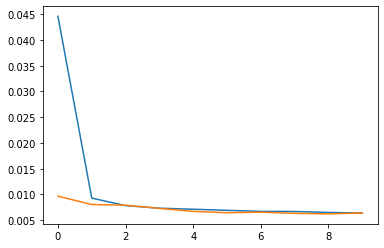

In [11]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'saved_models/MOVE_RETR_LSTM_CORRECT1.pt')
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [12]:
model.load_state_dict(torch.load('saved_models/MOVE_RETR_LSTM_CORRECT1.pt'))

predicted_output = predict(model, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                       precision    recall  f1-score   support

      booking-bookday      0.000     0.000     0.000         8
   booking-bookpeople      0.000     0.000     0.000        10
     booking-bookstay      0.000     0.000     0.000         6
     booking-booktime      0.000     0.000     0.000         7
         booking-name      0.000     0.000     0.000        11
          booking-ref      0.000     0.000     0.000        37
        hotel-address      0.625     0.180     0.280       111
           hotel-area      0.000     0.000     0.000       253
        hotel-bookday      0.000     0.000     0.000        42
     hotel-bookpeople      0.000     0.000     0.000        30
       hotel-bookstay      0.000     0.000     0.000        46
       hotel-booktime      0.000     0.000     0.000         0
       hotel-internet      0.000     0.000     0.000       157
           hotel-name      0.286     0.004     0.008       499
        hotel-parking      0.000     0.000     0.000  

/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packa